<a href="https://colab.research.google.com/github/YanisNC/Color-Classification-E-commerce-Clothes/blob/main/Color_Classification_on_E_commerce_Clothes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Color Classification on E-commerce Clothes

* To face this unsupervised learning problem, I've used a dataset that contains 5000 unlabeled images. 
* I've used the K-Means algorithm to cluster the N dominant colors of the images.
* Finally, we use a threshold, in the HSV color space, for the color that we want to detect from all the clothes.
* If any of the N dominant colors is inside this threshold, it's classified as this color.

### Import libraries

In [2]:
import numpy as np
import cv2
import os
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import glob
import tarfile
from tqdm import tqdm

### Import dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
tar = tarfile.open("/content/drive/My Drive/Colab Notebooks/Projects/shirts.tar.gz", "r:gz")
tar.extractall()
tar.close()

In [5]:
filenames = glob.glob("shirt_dataset/unlabeled/*")
filenames.sort()
print("Number of unlabeled images: ", len(filenames))

filenames_blue = glob.glob("shirt_dataset/labeled/*")
filenames_blue.sort()
print("Number of labeled images: ", len(filenames_blue))

Number of unlabeled images:  5000
Number of labeled images:  10


### Multi-functional class
This class will help us in our main tasks

In [6]:
class DominantColors:
    CLUSTERS = None
    IMAGE = None
    COLORS = None
    LABELS = None

    def __init__(self, image, clusters=3):
        self.CLUSTERS = clusters
        self.IMAGE = image


    def dominantColors(self):
        # read image
        img_src = cv2.imread(self.IMAGE)

        # percent by which the image is resized
        scale_percent = 10

        # calculate the 50 percent of original dimensions
        width = int(img_src.shape[1] * scale_percent / 100)
        height = int(img_src.shape[0] * scale_percent / 100)

        # dsize
        dsize = (width, height)

        # resize image
        small_img = cv2.resize(img_src, dsize)

        # convert to rgb from bgr
        img = cv2.cvtColor(small_img, cv2.COLOR_BGR2RGB)

        # reshaping to a list of pixels
        img = img.reshape((img.shape[0] * img.shape[1], 3))

        # save image after operations
        self.IMAGE = img

        # using k-means to cluster pixels
        kmeans = KMeans(n_clusters=self.CLUSTERS)
        kmeans.fit(img)

        # the cluster centers are our dominant colors.
        self.COLORS = kmeans.cluster_centers_

        # save labels
        self.LABELS = kmeans.labels_

        # returning after converting to integer from float
        return self.COLORS.astype(int)
    

    def rgb_to_hex(self, rgb):
        return '#%02x%02x%02x' % (int(rgb[0]), int(rgb[1]), int(rgb[2]))
    

    def rgb_to_hsv(self, rgb):
        r, g, b = rgb[0]/255.0, rgb[1]/255.0, rgb[2]/255.0
        mx = max(r, g, b)
        mn = min(r, g, b)
        df = mx-mn
        if mx == mn:
            h = 0
        elif mx == r:
            h = (60 * ((g-b)/df) + 360) % 360
        elif mx == g:
            h = (60 * ((b-r)/df) + 120) % 360
        elif mx == b:
            h = (60 * ((r-g)/df) + 240) % 360
        if mx == 0:
            s = 0
        else:
            s = (df/mx)*100
        v = mx*100

        return np.array((int(h), int(s), int(v)))
     

    def plotClusters(self):
        #plotting 
        fig = plt.figure()
        ax = Axes3D(fig)        
        for label, pix in zip(self.LABELS, self.IMAGE):
            ax.scatter(pix[0], pix[1], pix[2], color = self.rgb_to_hex(self.COLORS[label]))
        plt.show()
        
    
    def plotHistogram(self):
       
        #labels form 0 to no. of clusters
        numLabels = np.arange(0, self.CLUSTERS+1)
       
        #create frequency count tables    
        (hist, _) = np.histogram(self.LABELS, bins = numLabels)
        hist = hist.astype("float")
        hist /= hist.sum()
        
        #appending frequencies to cluster centers
        colors = self.COLORS
        
        #descending order sorting as per frequency count
        colors = colors[(-hist).argsort()]
        hist = hist[(-hist).argsort()] 
        
        #creating empty chart
        chart = np.zeros((50, 500, 3), np.uint8)
        start = 0
        
        #creating color rectangles
        for i in range(self.CLUSTERS):
            end = start + hist[i] * 500
            
            #getting rgb values
            r = colors[i][0]
            g = colors[i][1]
            b = colors[i][2]
            
            #using cv2.rectangle to plot colors
            cv2.rectangle(chart, (int(start), 0), (int(end), 50), (r,g,b), -1)
            start = end	
        
        #display chart
        plt.figure()
        plt.axis("off")
        plt.imshow(chart)
        plt.show()

### Let's use a sample image to see the how it works

In [37]:
clusters = 5
sample_image = filenames_blue[6]

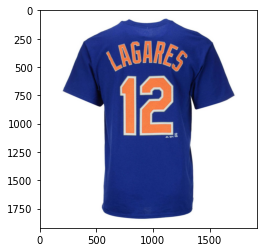

In [38]:
img = cv2.imread(sample_image)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

In [26]:
dc = DominantColors(sample_image, clusters) 
colors = dc.dominantColors()
print("RGB:\n", colors)
colors_hsv = [dc.rgb_to_hsv(color) for color in colors]
print("HSV:\n", colors_hsv)

RGB:
 [[ 29  48 129]
 [254 254 254]
 [243 127  73]
 [ 19  33 101]
 [172 162 164]]
HSV:
 [array([228,  77,  50]), array([ 0,  0, 99]), array([19, 69, 95]), array([229,  81,  39]), array([347,   5,  67])]


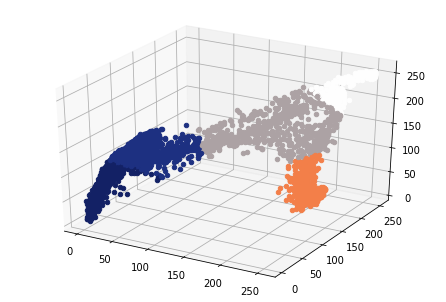

In [27]:
dc.plotClusters()

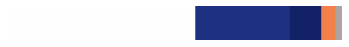

In [28]:
dc.plotHistogram()

### Color detection

I've established a threshold for blue in the HSV color space:


*   H: 180º - 240º
*   S: +20%
*   V: +20%


---



<img src=https://upload.wikimedia.org/wikipedia/commons/9/93/HSV_color_space_stereographic.png width="400">

In [39]:
for color in colors_hsv:
  if (color[0] >= 180) and (color[0] <= 240):
    if color[1] >= 20:
      if color[2] >= 20:
        print("There is a dominant blue color")
        print(color)

There is a dominant blue color
[228  77  50]
There is a dominant blue color
[229  81  39]


In [41]:
blue_shirts = []
for filename in tqdm(filenames):
  dc = DominantColors(filename, clusters) 
  colors = dc.dominantColors()

  colors_hsv = [dc.rgb_to_hsv(color) for color in colors]

  for color in colors_hsv:
    if (color[0] >= 180) and (color[0] <= 240):
      if color[1] >= 20:
        if color[2] >= 20:
          blue_shirts.append(filename)

100%|██████████| 5000/5000 [20:44<00:00,  4.02it/s]


In [42]:
len(blue_shirts)

1586

#### Executing the algorithm with 5 dominant colors

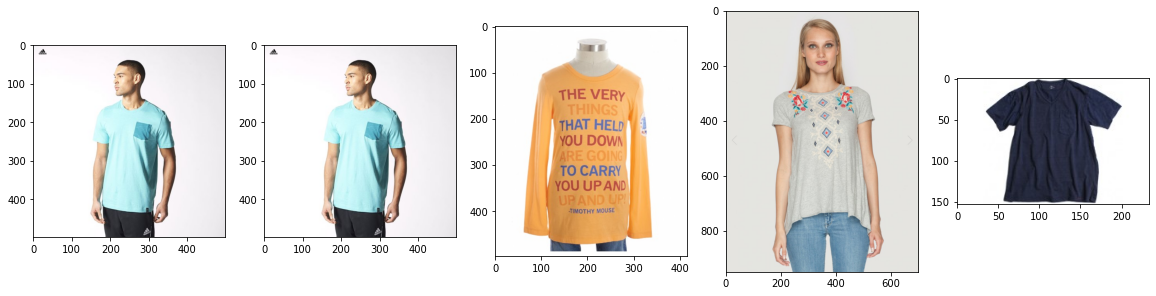

In [43]:
plt.figure(figsize=(20, 10))
for i in range(5):
  img = cv2.imread(blue_shirts[i])
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
  plt.subplot(1, 5, i+1)
  plt.imshow(img)

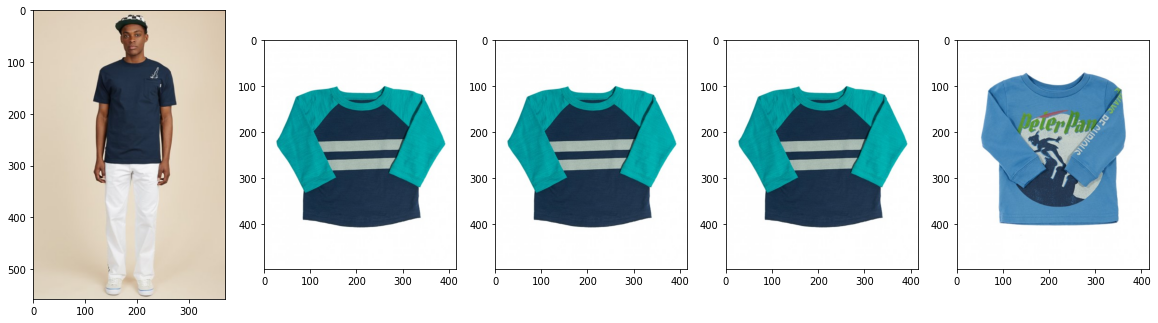

In [44]:
plt.figure(figsize=(20, 10))
for i in range(5,10):
  img = cv2.imread(blue_shirts[i])
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
  plt.subplot(1, 5, i-5+1)
  plt.imshow(img)

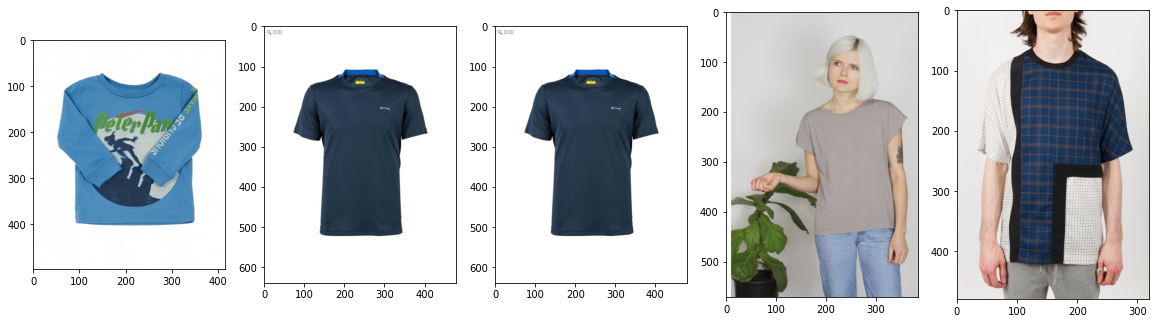

In [45]:
plt.figure(figsize=(20, 10))
for i in range(10,15):
  img = cv2.imread(blue_shirts[i])
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
  plt.subplot(1, 5, i-10+1)
  plt.imshow(img)

#### Executing the algorithm with 3 dominant colors

In [46]:
blue_shirts_3 = []
clusters = 3
for filename in tqdm(filenames):
  dc = DominantColors(filename, clusters) 
  colors = dc.dominantColors()

  colors_hsv = [dc.rgb_to_hsv(color) for color in colors]

  for color in colors_hsv:
    if (color[0] >= 180) and (color[0] <= 240):
      if color[1] >= 20:
        if color[2] >= 20:
          blue_shirts_3.append(filename)

100%|██████████| 5000/5000 [12:16<00:00,  6.79it/s]


In [47]:
len(blue_shirts_3)

807

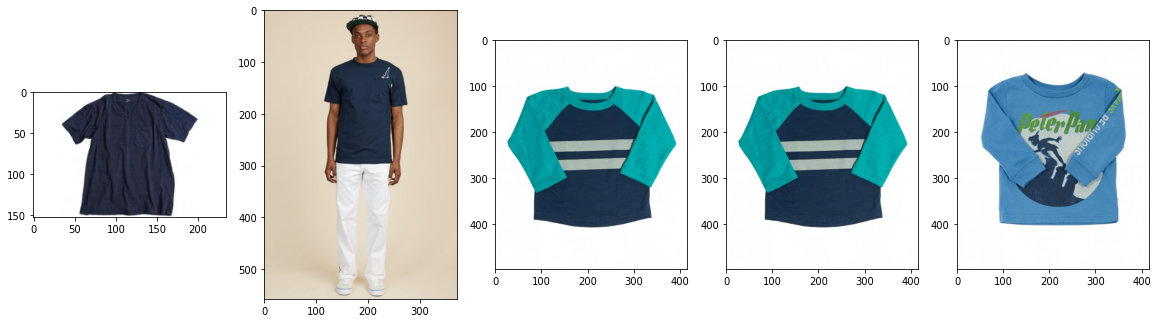

In [48]:
plt.figure(figsize=(20, 10))
for i in range(5):
  img = cv2.imread(blue_shirts_3[i])
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
  plt.subplot(1, 5, i+1)
  plt.imshow(img)

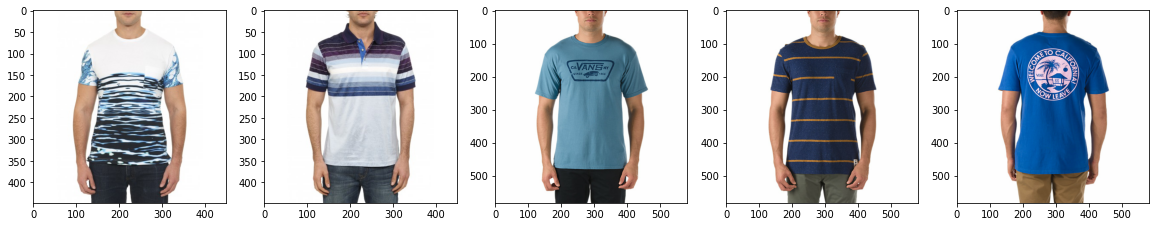

In [49]:
plt.figure(figsize=(20, 10))
for i in range(10,15):
  img = cv2.imread(blue_shirts_3[i])
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
  plt.subplot(1, 5, i-10+1)
  plt.imshow(img)

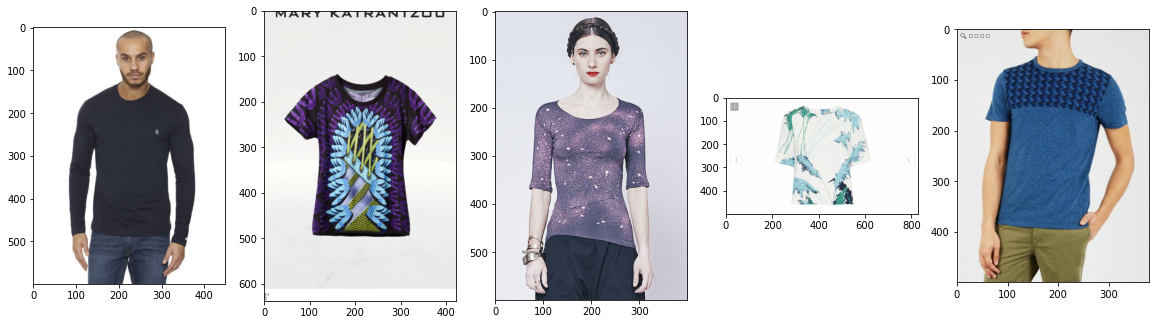

In [50]:
plt.figure(figsize=(20, 10))
for i in range(15,20):
  img = cv2.imread(blue_shirts_3[i])
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
  plt.subplot(1, 5, i-15+1)
  plt.imshow(img)

### Final Thoughts

* I've implemented a class to find the dominant colors of an image. To do this, I resize the image and convert it to RGB. After this, I use the K-Means algorithm to cluster the pixels of the image. The cluster centers are the dominant colors. After clustering the N dominant colors, we can visualize the clusters and a histogram of these colors. Finally I've looped over all the images in our dataset and saved the images, where blue is a dominant color, in a list. We can do this with every color, changing the threshold.

* As this is an unsupervised learning problem, to validate our model I've plotted some of the images where blue has been classified as a dominant color. We can also export the list and save the classified images in a folder.

* With more time and data I would have tried other clustering algorithms, as well as implementing a CNN or using semi-supervised learning.